# JWST NIRSpec MOS data

Simple DRAFT demo notebook to view NIRSpec MOS data. We'll start with the final products for a single galaxy: 2D and 1D spectra (S2D and X1D) extracted from all exposures combined. Then we'll work backward through pipeline steps to show the CAL / CRF files and finally RATE files. Includes scripts for downloading the default JWST pipeline products from the MAST archive.

See also: 
* NIRSpec MAST Query: https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/NIRSpec_MAST_Query/NIRSpec_MAST_Query.ipynb
* MOSViz: https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html
* NIRSpec MOS pipeline caveats: https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats
* JDAT: https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks
* files: https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html

NIRSpec plotting examples:
* https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_IFU/ero_nirspec_ifu_02732_demo.ipynb
* https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_MOS/nrs_mos_clean_1f_noise_workaround.ipynb
* https://github.com/spacetelescope/jwebbinar_prep/blob/faf56cd5f2cadca15e72be4180cd7f957ff3b1d8/mos_session/jwebbinar7_nirspecmos.ipynb
* https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/utils.py#L1971

## JWST ERO program 2736: SMACS0723 – JWST's "First Deep Field"

https://webbtelescope.org/contents/news-releases/2022/news-2022-035

Press release featured objects:  
 4590 z = 8.498 (13.1 Gyr ago)  
10612 z = 7.663 (13.0 Gyr ago)  
 8140 z = 5.275 (12.6 Gyr ago)  
 9922 z = 2.743 (11.3 Gyr ago)  
and a few others:  
6355 z = 7.665  ** We'll look at this one ** excellent spectrum with bright lines  
5144 z = 6.383  

Observations:
* two pointings: s007, s008  
* G235M & G395M
* 3 slitlet nods x 2 integrations x 20 groups NRSIRS2 = 8841 s exposure time = 2.5 hours

## JWST Science Calibration Pipeline
https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview  
https://jwst-pipeline.readthedocs.io  

### Pipeline Stages
uncal (counts) –> rate (slopes) –> cal (calibrated) –> s2d (2D spectra) –> x1d (1D spectra)

# Import packages

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [3]:
cmap = 'RdBu'
bad_lum = 0.88
bad_color = bad_lum, bad_lum, bad_lum

In [4]:
import jwst
from jwst import datamodels

In [5]:
import json  # Association files

In [6]:
from astroquery.mast import Observations, Mast

def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    # https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [7]:
download_dir = 'data'

# 2D and 1D spectrum

Load s2d and x1d files from all exposures combined by Spec3Pipeline

In [8]:
source_id = 6355
s2d_file = 'jw02736-o007_s%05d_nirspec_f290lp-g395m_s2d.fits' % source_id
x1d_file = s2d_file.replace('s2d', 'x1d')
#s2d_file = os.path.join(data_dir, s2d_file)
s2d_file, x1d_file = download_jwst_files([s2d_file, x1d_file], download_dir)

INFO: Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits with expected size 1566720. [astroquery.query]
INFO: Found cached file data/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits with expected size 250560. [astroquery.query]


In [9]:
# load as datamodels
s2d_model = datamodels.open(s2d_file) 
x1d_model = datamodels.open(x1d_file) 

In [10]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w'): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    #ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    #ystart = ny/2 - 4
    #ystop  = ny/2 + 4
    #for sgn in -1,+1:
    #    ax2d.axhline(num_cross/2+sgn*width_1d, c='w', lw=0.5, alpha=0.5, ls='--')
    #for y in ystart, ystop:
    #    ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    #ax1d.set_ylim(-2e-6, 2e-5)
    #ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    plt.xticks(xtick_pos, xtick_labels)
    ax2d.set_yticks([0, (ny-1)/2., ny-1])
    plt.xlabel('wavelength (microns)');

#show_MOS_spectrum(s2d_model, x1d_model, source_id)

2023-12-31 05:03:43,450 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -0.8692266345024109 0.8521444201469421


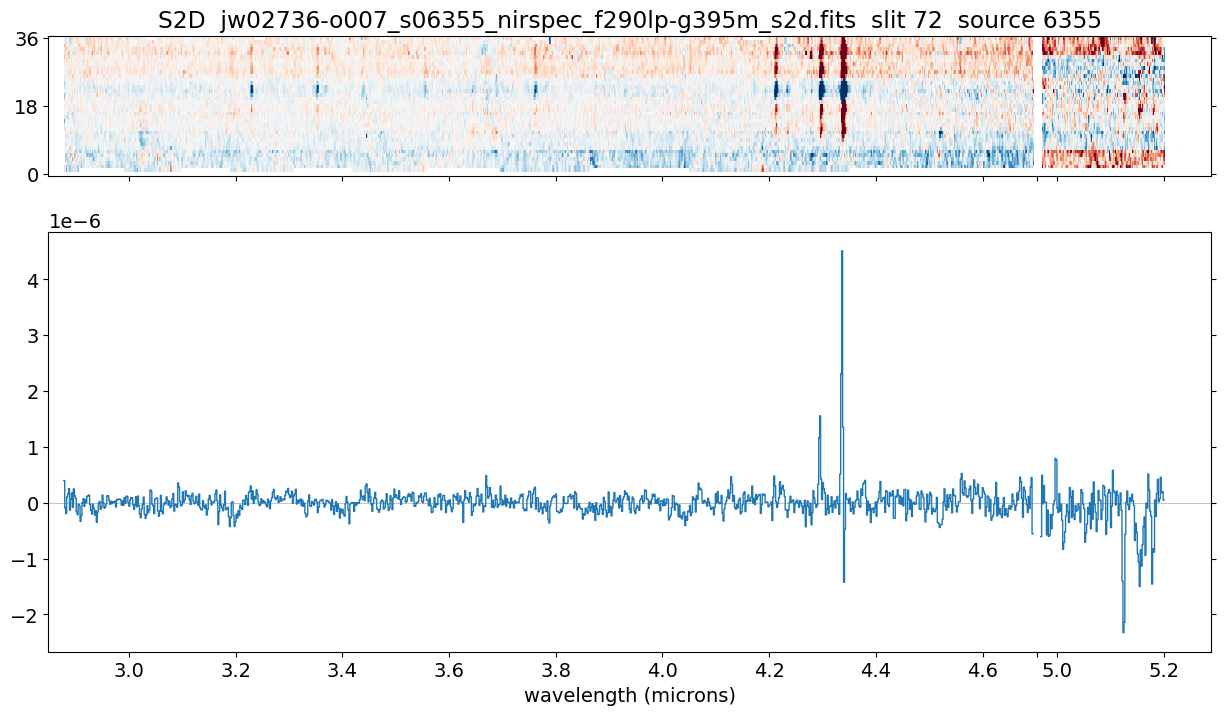

In [11]:
show_MOS_spectrum(s2d_model, x1d_model, source_id) # , cmap=cmap, bad_color=bad_color)

Note the 1D extraction sometimes misses the signal. This can be improved significantly simply by tweaking the extraction rows ystart – ystop as we'll demonstrate in another notebook in prep. Also note the x1d file doesn't save the ystart – ystop range used. Above, the center row is marked on the y axis.

## S2D ERROR array

In [12]:
cmap = 'viridis'
bad_color = 1, 0.7, 0.7
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

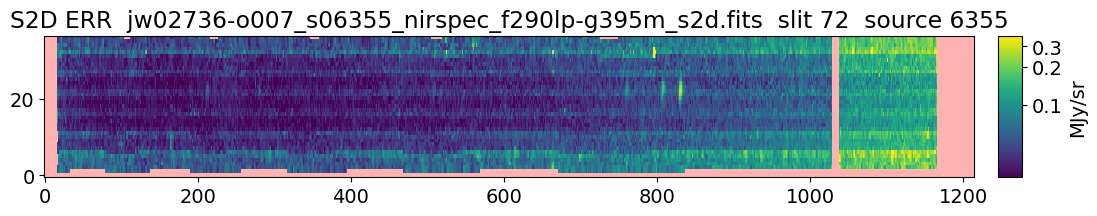

In [13]:
# Error array
s2d_err = s2d_model.err + 0
s2d_err = np.where(s2d_err, s2d_err, np.nan)  # Replace zeros with nan where there is no data
data = s2d_err + 0
#data = np.where(np.isnan(s2d_err), np.nan, data)

fig, ax = plt.subplots(1, 1, figsize=(12,3))
norm = simple_norm(data, 'asinh', min_percent=2, max_percent=99.925)
im = ax.imshow(data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
title = 'S2D ERR  ' + os.path.basename(s2d_model.meta.filename) + '  slit %d' % s2d_model.slitlet_id + '  source %d' % s2d_model.source_id
plt.title(title)
units = 'MJy/sr'
ax.set_aspect(5)
#plt.colorbar(im, ax=ax, label=units, aspect=5, pad=0.02, shrink=0.51)
cbar_ax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.02, ax.get_position().height]) # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(im, label=units, cax=cbar_ax)

## S2D datamodel contents

In [14]:
s2d_model.info()  
#s2d_model.info(max_rows=99999)  # show entire contents

root (AsdfObject)
├─asdf_library (Software) ...
├─history (dict) ...
├─_fits_hash (str): 3f6ab50ab6ea20d518ae5fffa2fe7ee0363929dfd898de80dd6bd0dec587358b
├─con (ndarray): shape=(1, 37, 1215), dtype=int32
├─data (ndarray): shape=(37, 1215), dtype=float32
├─err (ndarray): shape=(37, 1215), dtype=float32
├─hdrtab (FITS_rec): shape=(6,), dtype=record34352
├─meta (dict) ...
├─name (str): 72
├─shutter_id (int): 30433
├─shutter_state (str): 1x111
├─slitlet_id (int): 72
├─source_alias (str): 6355
├─source_dec (float): -73.4350589621277
├─source_id (int): 6355
├─source_name (str): 2736_6355
├─source_ra (float): 110.84459416965377
├─source_type (str): EXTENDED
├─source_xpos (float): -0.0356217622756958
├─source_ypos (float): 0.36562544107437134
├─stellarity (float): 0.1
└─8 not shown
Some nodes not shown.


In [15]:
s2d_model.__dict__['_instance'].keys()

dict_keys(['asdf_library', 'history', '_fits_hash', 'con', 'data', 'err', 'hdrtab', 'meta', 'name', 'shutter_id', 'shutter_state', 'slitlet_id', 'source_alias', 'source_dec', 'source_id', 'source_name', 'source_ra', 'source_type', 'source_xpos', 'source_ypos', 'stellarity', 'var_flat', 'var_poisson', 'var_rnoise', 'wht', 'xsize', 'xstart', 'ysize', 'ystart'])

In [16]:
s2d_model.source_ra, s2d_model.source_dec

(110.84459416965377, -73.4350589621277)

In [17]:
# list(s2d_model)
for key in list(s2d_model):
    print(key, end='  ')

asdf_library.author  asdf_library.homepage  asdf_library.name  asdf_library.version  history.extensions  _fits_hash  con  data  err  hdrtab  meta.aperture.name  meta.aperture.position_angle  meta.aperture.pps_name  meta.asn.exptype  meta.asn.pool_name  meta.asn.table_name  meta.bunit_data  meta.bunit_err  meta.cal_step.assign_wcs  meta.cal_step.back_sub  meta.cal_step.barshadow  meta.cal_step.dark_sub  meta.cal_step.dq_init  meta.cal_step.extract_2d  meta.cal_step.flat_field  meta.cal_step.gain_scale  meta.cal_step.group_scale  meta.cal_step.imprint  meta.cal_step.ipc  meta.cal_step.jump  meta.cal_step.linearity  meta.cal_step.master_background  meta.cal_step.msa_flagging  meta.cal_step.outlier_detection  meta.cal_step.pathloss  meta.cal_step.photom  meta.cal_step.pixel_replace  meta.cal_step.ramp_fit  meta.cal_step.refpix  meta.cal_step.resample  meta.cal_step.saturation  meta.cal_step.srctype  meta.cal_step.superbias  meta.calibration_software_revision  meta.calibration_software_vers

In [18]:
s2d_model.meta.cal_step.__dict__['_instance']

{'assign_wcs': 'COMPLETE',
 'back_sub': 'COMPLETE',
 'barshadow': 'COMPLETE',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'extract_2d': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'COMPLETE',
 'group_scale': 'COMPLETE',
 'imprint': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'linearity': 'COMPLETE',
 'master_background': 'SKIPPED',
 'msa_flagging': 'COMPLETE',
 'outlier_detection': 'COMPLETE',
 'pathloss': 'COMPLETE',
 'photom': 'COMPLETE',
 'pixel_replace': 'SKIPPED',
 'ramp_fit': 'COMPLETE',
 'refpix': 'COMPLETE',
 'resample': 'COMPLETE',
 'saturation': 'COMPLETE',
 'srctype': 'COMPLETE',
 'superbias': 'COMPLETE'}

In [19]:
s2d_model.meta.cal_step.master_background

'SKIPPED'

In [20]:
s2d_model.meta.cal_step.__getattr__('pathloss')

'COMPLETE'

## X1D datamodel contents

In [21]:
x1d_model.info()  

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 4190c5ef01fd3a52c43d2c6df6a9c56726cc3ecef156be05ce1e0851a20429e6
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─background (dict)
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.11.4
│ ├─compress (bool): False
│ ├─data_processing_software_version (str): 2023_2a
│ ├─date (str): 2023-11-18T06:34:36.548
│ ├─dither (dict) ...
│ ├─exposure (dict) ...
│ └─23 not shown
└─spec (list) ...
Some nodes not shown.


In [22]:
#list(x1d_model.spec[0])
x1d_model.spec[0].__dict__['_instance'].keys()

dict_keys(['dispersion_direction', 'meta', 'name', 'shutter_state', 'slit_dec', 'slit_ra', 'slitlet_id', 'source_alias', 'source_dec', 'source_id', 'source_name', 'source_ra', 'source_type', 'source_xpos', 'source_ypos', 'spec_table', 'spectral_order', 'stellarity'])

In [23]:
x1d_model.__dict__['_instance'].keys()

dict_keys(['asdf_library', 'history', '_fits_hash', 'meta', 'spec'])

# CAL and CRF

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#cosmic-ray-flagged-data-crf-and-crfints

CRF files are identical to CAL. "The only difference is that the DQ arrays have been updated to contain CR flags."

In [25]:
cal_file = s2d_file.replace('s2d', 'cal')
crf_file = s2d_file.replace('s2d', 'crf')

cal_file, crf_file = download_jwst_files([cal_file, crf_file], download_dir)

#print(cal_file, os.path.exists(cal_file))
#print(crf_file, os.path.exists(crf_file))

cal_model = datamodels.open(cal_file) 
crf_model = datamodels.open(crf_file) 

#cal_hdu_list = fits.open(cal_file)
#crf_hdu_list = fits.open(crf_file)

In [26]:
def show_MOS_CAL(cal_model, ext='SCI', vmin=None, vmax=None):
    fig, axs = plt.subplots(3, 1, figsize=(15,8), squeeze=True, sharex=True)

    for iplot in 0,1,2:
        ical = 2 * iplot

        units = 'MJy/sr'
        if ext == 'SCI':
            data = cal_model.exposures[ical].data + 0
            cmap = 'RdBu'
            bad_color = 'w'
        elif ext == 'ERR':
            data = cal_model.exposures[ical].err + 0
            cmap = 'viridis'
            bad_color = 1, 0.7, 0.7
        elif ext == 'DQ':
            data = cal_model.exposures[ical].dq + 0
            data = np.log2(data)  # 'white' is good: no flags set: log(0) = -inf
            vmin, vmax = 0, 32
            cmap = 'turbo'
            bad_color = 'w'
            units = 'flag bit'
            
        if vmin == vmax == None:
            sigma_clipped_data = sigma_clip(data, sigma=5, maxiters=3)
            vmin = np.min(sigma_clipped_data)
            vmax = np.max(sigma_clipped_data)

        cmap = matplotlib.colormaps[cmap]
        cmap.set_bad(bad_color, 1.)
                 
        left   = cal_model.exposures[ical].xstart
        right  = cal_model.exposures[ical].xsize + left
        bottom = cal_model.exposures[ical].ystart
        top    = cal_model.exposures[ical].ysize + bottom
        extent = left, right, bottom, top
                        
        ax = axs[iplot]
        im = ax.imshow(data, extent=extent, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap, aspect='auto', interpolation='nearest') # , norm=norm
        plt.colorbar(im, ax=ax, label=units, aspect=10, pad=0.02)
        ax.set_aspect(5)

    filename = cal_model.meta.filename
    filename_ext = filename.split('_')[-1].split('.')[0]
    title = filename_ext.upper()
    if ext != 'SCI':
        title += ' ' + ext
    title += '  ' + filename
    title += '  slit %d'   % cal_model.exposures[ical].slitlet_id
    title += '  source %d' % cal_model.exposures[ical].source_id
    axs[0].set_title(title)

2023-12-31 05:04:08,434 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


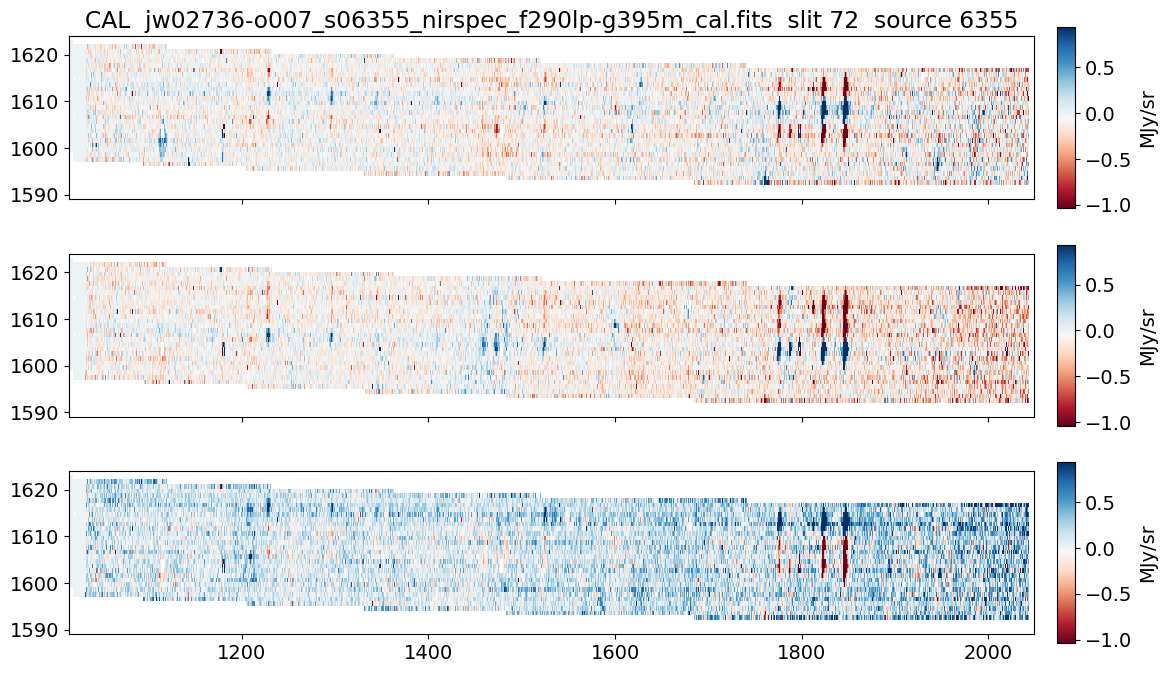

In [27]:
show_MOS_CAL(cal_model)

2023-12-31 05:04:08,913 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


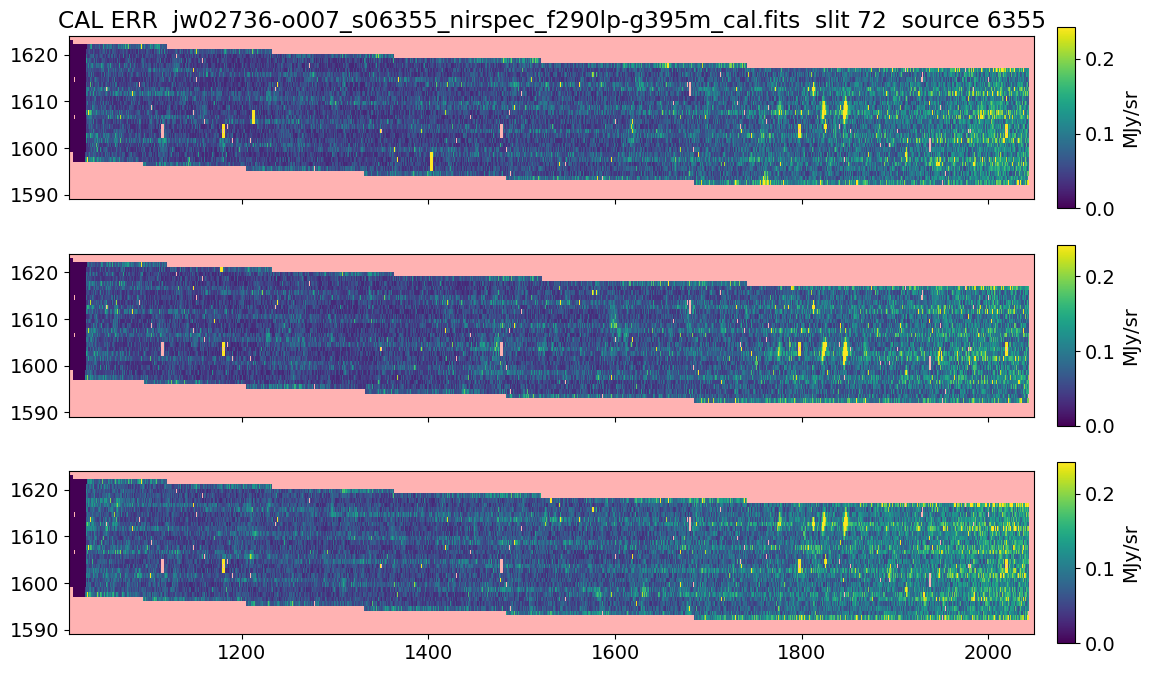

In [28]:
show_MOS_CAL(cal_model, 'ERR')

### Data Quality flags

https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags

https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats

"Pipeline stage 3 processing includes an outlier rejection step that depends on the noise properties of the individual exposure-level input data. The "crf.fits" output of this step should be checked to verify the performance. If too many pixels are being rejected, raise the S/N threshold using the snr step argument until the results look reasonable. The step should be turned off if the number of input exposures is small (~3 or less)."


/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_36232/700041483.py:18: RuntimeWarning: divide by zero encountered in log2
  data = np.log2(data)  # 'white' is good: no flags set: log(0) = -inf


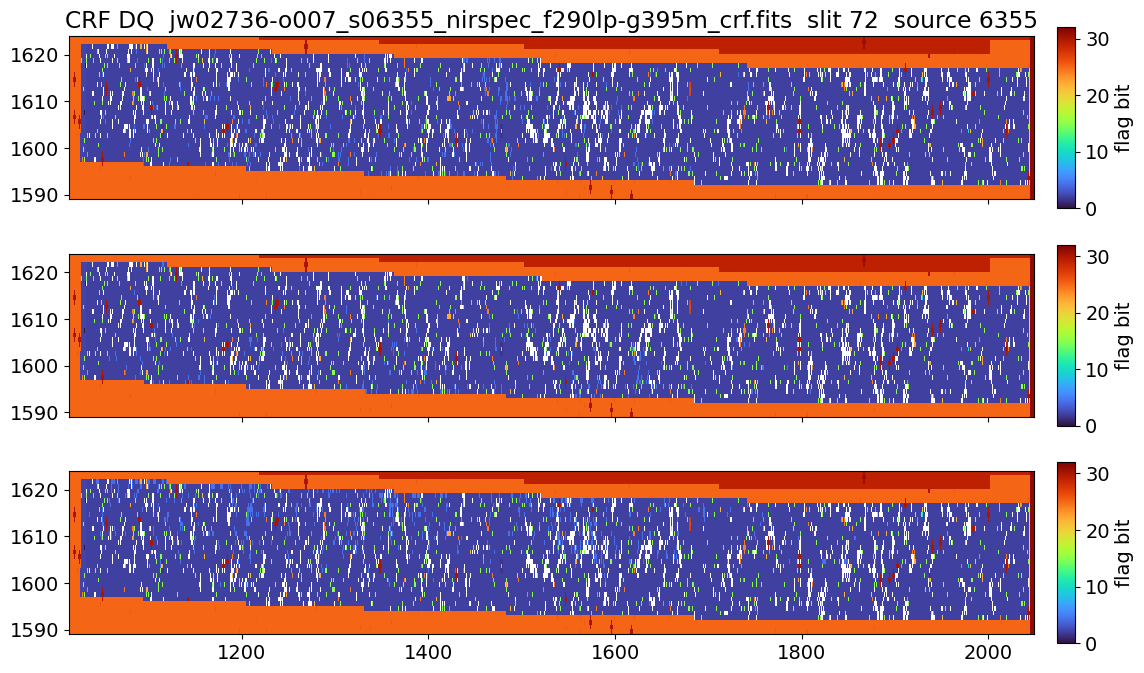

In [29]:
show_MOS_CAL(crf_model, 'DQ')

In [30]:
cal_model.__dict__['_instance'].keys()

dict_keys(['asdf_library', 'history', '_fits_hash', 'exposures', 'meta', 'slits'])

In [31]:
for key in cal_model.exposures[0]:
    print(key, end='  ')

barshadow  data  dither_position  dq  err  int_times  meta.aperture.name  meta.aperture.position_angle  meta.aperture.pps_name  meta.asn.exptype  meta.asn.pool_name  meta.asn.table_name  meta.bunit_data  meta.bunit_err  meta.cal_step.assign_wcs  meta.cal_step.back_sub  meta.cal_step.barshadow  meta.cal_step.dark_sub  meta.cal_step.dq_init  meta.cal_step.extract_2d  meta.cal_step.flat_field  meta.cal_step.gain_scale  meta.cal_step.group_scale  meta.cal_step.imprint  meta.cal_step.ipc  meta.cal_step.jump  meta.cal_step.linearity  meta.cal_step.master_background  meta.cal_step.msa_flagging  meta.cal_step.pathloss  meta.cal_step.photom  meta.cal_step.pixel_replace  meta.cal_step.ramp_fit  meta.cal_step.refpix  meta.cal_step.saturation  meta.cal_step.srctype  meta.cal_step.superbias  meta.calibration_software_revision  meta.calibration_software_version  meta.compress  meta.coordinates.reference_frame  meta.data_processing_software_version  meta.date  meta.dither.nod_type  meta.dither.positi

In [32]:
cal_model.exposures[0].meta.wcsinfo.s_region

'POLYGON ICRS  110.712683332 -73.461398835 110.879201003 -73.499201025 111.012438173 -73.452221627 110.847979591 -73.413862059'

In [33]:
list(cal_model.exposures[0].meta.wcsinfo) #.s_region

['dec_ref',
 'dispersion_direction',
 'ra_ref',
 'roll_ref',
 's_region',
 'specsys',
 'spectral_order',
 'spectral_region',
 'v2_ref',
 'v3_ref',
 'v3yangle',
 'velosys',
 'vparity',
 'waverange_end',
 'waverange_start']

In [34]:
crf_hdu_list = fits.open(crf_file)
crf_hdu_list.info()

Filename: data/jw02736-o007_s06355_nirspec_f290lp-g395m_crf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  SCI           1 ImageHDU        98   (1034, 35)   float32   
  2  DQ            1 ImageHDU        11   (1034, 35)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        10   (1034, 35)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (1034, 35)   float32   
  5  BARSHADOW     1 ImageHDU         9   (1034, 35)   float32   
  6  AREA          1 ImageHDU         9   (1034, 35)   float32   
  7  VAR_POISSON    1 ImageHDU         9   (1034, 35)   float32   
  8  VAR_RNOISE    1 ImageHDU         9   (1034, 35)   float32   
  9  VAR_FLAT      1 ImageHDU         9   (1034, 35)   float32   
 10  SCI           2 ImageHDU        72   (181, 29)   float32   
 11  DQ            2 ImageHDU        11   (181, 29)   int32 (rescales to uint32)   
 12  ERR           2 ImageHDU        10   (181, 29)   float

# Rate file

In [35]:
spec3_asn_file = cal_model.exposures[0].meta.asn.table_name
download_jwst_files([spec3_asn_file], download_dir)

2023-12-31 05:04:12,676 - stpipe - INFO - Found cached file data/jw02736-o007_20231116t144653_spec3_00001_asn.json with expected size 5501.


INFO: Found cached file data/jw02736-o007_20231116t144653_spec3_00001_asn.json with expected size 5501. [astroquery.query]


['data/jw02736-o007_20231116t144653_spec3_00001_asn.json']

In [36]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

jw02736007001_03103_00001_nrs1_cal.fits
jw02736007001_03103_00001_nrs2_cal.fits
jw02736007001_03103_00002_nrs1_cal.fits
jw02736007001_03103_00002_nrs2_cal.fits
jw02736007001_03103_00003_nrs1_cal.fits
jw02736007001_03103_00003_nrs2_cal.fits


In [37]:
spec2_cal_file1 = spec2_cal_files[0]
spec2_cal_file1 = os.path.join(download_dir, spec2_cal_file1)
spec2_cal_file2 = spec2_cal_file1.replace('nrs1', 'nrs2')
download_jwst_files([spec2_cal_file1, spec2_cal_file2], download_dir)

2023-12-31 05:04:13,938 - stpipe - INFO - Found cached file data/jw02736007001_03103_00001_nrs1_cal.fits with expected size 37635840.
2023-12-31 05:04:14,055 - stpipe - INFO - Found cached file data/jw02736007001_03103_00001_nrs2_cal.fits with expected size 58786560.


INFO: Found cached file data/jw02736007001_03103_00001_nrs1_cal.fits with expected size 37635840. [astroquery.query]
INFO: Found cached file data/jw02736007001_03103_00001_nrs2_cal.fits with expected size 58786560. [astroquery.query]


['data/jw02736007001_03103_00001_nrs1_cal.fits',
 'data/jw02736007001_03103_00001_nrs2_cal.fits']

In [38]:
spec2_cal_model1 = datamodels.open(spec2_cal_file1)
spec2_cal_model2 = datamodels.open(spec2_cal_file2)

In [39]:
rate_file1 = spec2_cal_file1.replace('_cal.fits', '_rate.fits')
rate_file2 = rate_file1.replace('nrs1', 'nrs2')
download_jwst_files([rate_file1, rate_file2], download_dir)

2023-12-31 05:04:43,750 - stpipe - INFO - Found cached file data/jw02736007001_03103_00001_nrs1_rate.fits with expected size 83943360.
2023-12-31 05:04:43,877 - stpipe - INFO - Found cached file data/jw02736007001_03103_00001_nrs2_rate.fits with expected size 83943360.


INFO: Found cached file data/jw02736007001_03103_00001_nrs1_rate.fits with expected size 83943360. [astroquery.query]
INFO: Found cached file data/jw02736007001_03103_00001_nrs2_rate.fits with expected size 83943360. [astroquery.query]


['data/jw02736007001_03103_00001_nrs1_rate.fits',
 'data/jw02736007001_03103_00001_nrs2_rate.fits']

In [40]:
def show_MOS_rate(rate_file, slits_model, save_plot=False, close_plot=False, integration=None):
    # slits_model can be either s2d or cal from spec2 -- contains slit models for all the sources
    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    #ax.imshow(data, origin='lower', vmin=-0.004, vmax=0.022, interpolation='nearest')
    norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
    #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    #print(norm.vmin, norm.vmax)
    #im  = ax.imshow(data, origin='lower', cmap='viridis', norm=norm, interpolation='none')
    im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    

    if 0:
        path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]  # add white outline to text below
        fontsize = 12
        color = 'r'
    else:
        path_effects = []  # no outline
        fontsize = 7
        color = 'w'
    
    slit_patches = []
    for slit in slits_model.slits:
        slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
        slit_patches.append(slit_patch)
        y = slit.ystart + slit.ysize/2
        va = 'center'
        if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
            x = slit.xstart
            ha = 'right'
        else: # Label the spectra on the right hand side for NRS2: 
            x = slit.xstart + slit.xsize
            ha = 'left'
        plt.text(x, y, slit.source_id, color=color, ha=ha, va=va, fontsize=fontsize, path_effects=path_effects, weight='bold')
    
    ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))
    
    title = os.path.basename(rate_file)
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    plt.title(title)
    print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

jw02736007001_03103_00001_nrs1_rate.fits


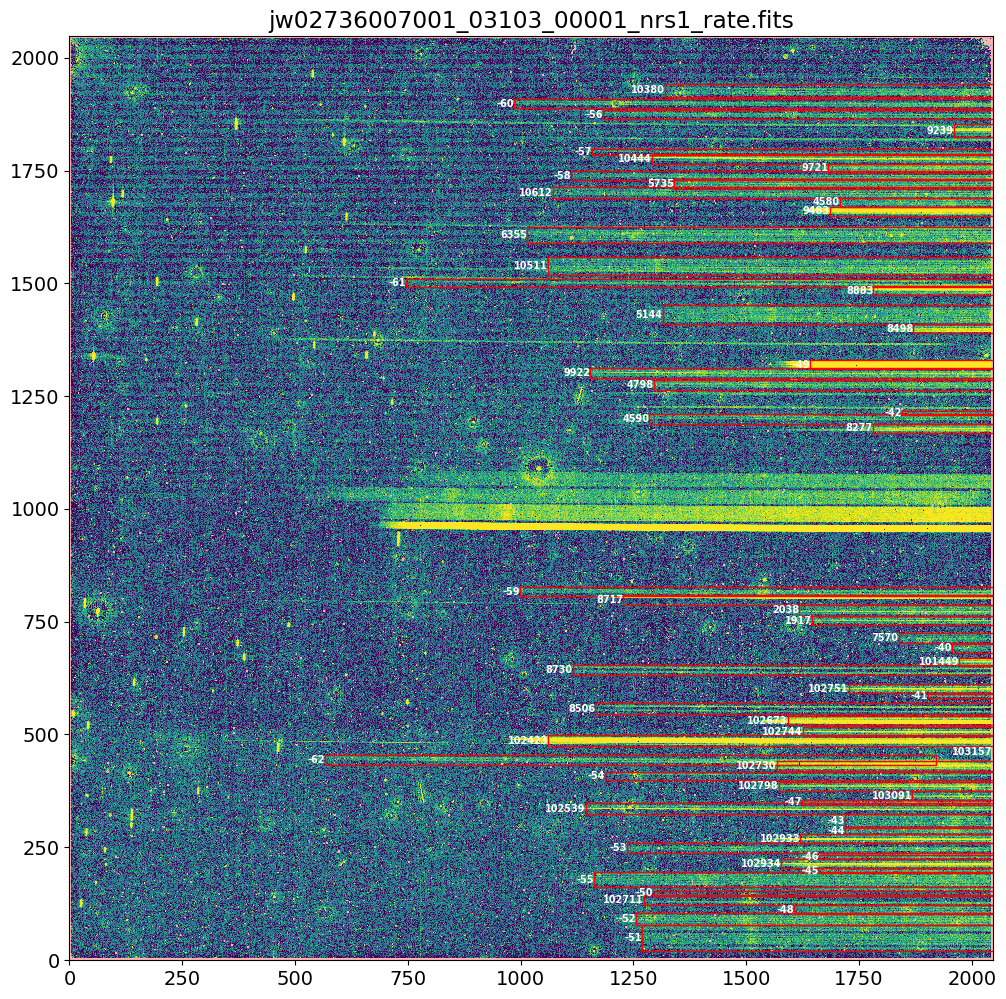

In [41]:
show_MOS_rate(rate_file1, spec2_cal_model1)

In [42]:
def show_MOS_rate_files(rate_files, slit_models, save_plot=False, close_plot=False, integration=None):
    fig, axs = plt.subplots(1, len(rate_files), figsize=(15,8), sharey=True)
    plt.subplots_adjust(wspace=0.02)

    for ifile, rate_file in enumerate(rate_files):        
        if not os.path.exists(rate_file):
            continue
            
        with fits.open(rate_file) as hdu_list:
            data = hdu_list['SCI'].data
            if integration == 'min':
                data = data.min(axis=0)
            elif integration != None:
                data = data[integration]

        ax = axs[ifile]
        #norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
        norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
        #print(norm.vmin, norm.vmax)
        # Turn off interpolation! Or else bad pixels will appear to grow in the plot
        im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')
        
        # Labels 2D extraction regions on MSA detector rate image
        slit_model = slit_models[ifile]
        slit_patches = []
        path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]
        fontsize = 8
        for slit in slit_model.slits:
            slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
            slit_patches.append(slit_patch)
            #plt.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='w', va='center', fontsize=12, weight='bold')
            #print('nrs1' in rate_file)
            if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
                ax.text(slit.xstart, slit.ystart + slit.ysize/2, slit.source_id, color='r', ha='right', va='center', fontsize=fontsize, path_effects=path_effects)
            else:  # 'nrs2' # Label the spectra on the right hand side for NRS2:
                ax.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='r', va='center', fontsize=fontsize, path_effects=path_effects)
        
        ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))
        
        title = os.path.basename(rate_file)
        if integration != None:
            title = title.replace('rateints', 'rateints[%s]' % integration)
    
        ax.set_title(title)
        print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        print('SAVING', save_plot)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

jw02736007001_03103_00001_nrs1_rate.fits
jw02736007001_03103_00001_nrs2_rate.fits


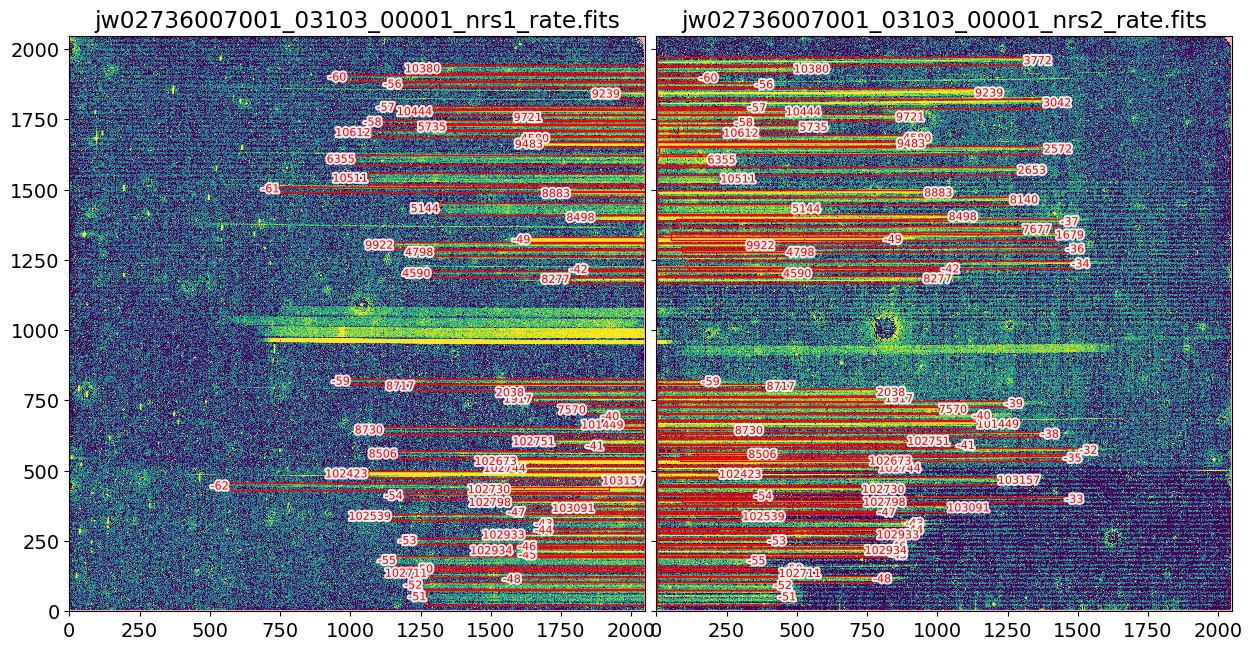

In [43]:
show_MOS_rate_files([rate_file1, rate_file2], [spec2_cal_model1, spec2_cal_model2])